# **Purpose**

...multilabel classification with multiple modalities...

# **Imports & Settings**

In [1]:
from utils_models import *
from utils_dataloaders import *
from utils_training import *

from mulltilabel2 import *

from multilabel_update import *

import itertools
import json
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

##### set dataframe display options 
# show decimal format (not scientific notation)
pd.options.display.float_format = '{:.4f}'.format

# display all columns
pd.set_option('display.max_columns', None)

In [2]:
#####################
# Confirm GPU Status
#####################

if torch.cuda.is_available():
    print('GPU available...')
else:
    print('GPU NOT available...')

GPU NOT available...


# **Parameters**

In [3]:
########################
# Model Directory Setup
########################

###### unique name for model (used for directory and associated files)
model_name = 'test'

###### directory for model output
model_dir = f"../models/classification/{model_name}"
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)
else:
    print('Directory already exists!!!\nChange directory or will be Overwritten!!!')

Directory already exists!!!
Change directory or will be Overwritten!!!


In [4]:
###############
# Model Setup
###############

###### model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_epochs = 3


###### dictionary of modalities for model (informal name with unique identifier filename)
modalities = {
    'dem': ['dem.tif'], 
    'rgb': ['aerialr.tif', 'aerialg.tif', 'aerialb.tif'], 
    # 'slope': ['logslope.tif'], 
    # 'slope': ['logslope.tif', 'logslope_10.tif', 'logslope_20.tif', 'logslope_50.tif', 'logslope_100.tif', 'logslope_200.tif']
    }


##### attention (None, self attention (1 modality), or cross attention (>=2  modalities))
# NOTE: must match modalities; query applied to first, and key/value applied to second
# attention_configs = None
# attention_configs = {'sa_dem': ['dem']}
# attention_configs = {}
# modality_permutations = list(itertools.permutations(modalities.keys(), 2))
# attn_name_prefix = 'ca_' if len(modality_permutations) > 1 else 'sa_'
# for combo in modality_permutations:
#     attn_name = attn_name_prefix + '_'.join(combo)
#     attention_configs[attn_name] = combo


##### encoder weights (pretrained or random initialization)
# weights_config = None
weights_config = 'IMAGENET1K_V2'


# ##### encoder class
# encoder = ResNextEncoder(weights_config).to(device)


# ##### initialize full model
# model = MultilabelClassification(modality_configs=modalities, encoder=encoder, attention_configs=attention_configs).to(device)


model = FullModel2(num_classes=7)

##### optimizer
optimizer = optim.Adam(model.parameters())


##### focal loss
reduction = 'mean'
gamma = 2

# alpha...
alpha = 0.25
# alpha = [0.25, 0.25, 0.25*10, 0.25*10, 0.25, 0.25, 0.25]
# target_path = glob.glob(r'../data/warren/*_labels.csv')[0]                        # path to patch labels
# targets = pd.read_csv(target_path)                                                # read as dataframe
# targets = targets.iloc[:, 1:]                                                     # extract binary targets
# alpha = (len(targets) * targets.shape[1]) / targets.sum(axis=0).to_numpy()        # inverse class frequency
# alpha = np.sqrt(alpha)                                                            # square root of inverse class frequencies
# alpha = alpha / alpha.sum()                                                       # scale weights so they sum to 1
alpha = torch.tensor(alpha, dtype=torch.float32).view(1, -1).to(device)           # convert to tensor


criterion = FocalLoss(alpha=alpha, gamma=gamma, reduction=reduction).to(device)   # initialize focal loss


In [5]:
################
# Patches Setup
################

###### paths to patch GeoJSONs
train_patch_path = r'../models/patches/warren_patches_train.geojson'
val_patch_path = r'../models/patches/warren_patches_val.geojson'
test_patch_path = r'../models/patches/warren_patches_test.geojson'
hardin_test_patch_path = r'../models/patches/hardin_patches_test.geojson'

###### directories where patches are stored
patch_dir = r'../data/patches_warren'           # main set
hardin_patch_dir = r'../data/patches_hardin'    # secondary test set


####### normalization parameters
norm_stats_path = r'../data/warren/image_stats.csv'
df = pd.read_csv(norm_stats_path)
norm_params = {}
for modality, channels in modalities.items():
    means = []
    stds = []
    for channel in channels:
        stats = df.loc[df['path']==channel]
        means.append(stats['mean'].item())
        stds.append(stats['std'].item())
    norm_params[modality] = [means, stds]


In [6]:
######
# Log
######

##### initialize dictionaries for log
metadata = {}
patches_meta = {}
modalities_meta = {}
hyper_meta = {}
model_meta = {}

##### collect setup info
metadata['NAME'] = model_name
metadata['DIRECTORY'] = model_dir

##### collect patches info
patches_meta['training patch polygons'] = train_patch_path
patches_meta['training patches directory'] = patch_dir
patches_meta['validation patch polygons'] = val_patch_path
patches_meta['validation patches directory'] = patch_dir
patches_meta['testing patch polygons'] = test_patch_path
patches_meta['testing patches directory'] = patch_dir
patches_meta['external testing patch polygons'] = hardin_test_patch_path if not hardin_test_patch_path is None else None
patches_meta['external testing patches directory'] = hardin_patch_dir if not hardin_patch_dir is None else None
metadata['PATCHES'] = patches_meta

##### collect modalitiy info
modalities_meta['modalities'] = modalities
modalities_meta['normalization values'] = norm_params
metadata['MODALITIES'] = modalities_meta

##### collect hyperparameters info
hyper_meta['batch size'] = batch_size
hyper_meta['epochs'] = num_epochs
hyper_meta['optimizer'] = type(optimizer).__name__
hyper_meta['learning rate'] = optimizer.param_groups[0]['lr']
hyper_meta['weight decay'] = optimizer.param_groups[0].get('weight_decay', None)
hyper_meta['momentum'] = optimizer.param_groups[0].get('momentum', None)
hyper_meta['loss'] = type(criterion).__name__
hyper_meta['alpha'] = criterion.alpha.cpu().numpy().tolist()
hyper_meta['gamma'] = criterion.gamma
metadata['HYPERPARAMETERS'] = hyper_meta

##### collect model info
# model_meta['encoder'] = type(encoder).__name__
model_meta['encoder'] = 'resnext'

model_meta['weights'] = weights_config

# model_meta['attention'] = attention_configs
model_meta['attention'] = "cross"

model_meta['model'] = type(model).__name__
metadata['MODEL'] = model_meta

##### write log to json
with open(f"{model_dir}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=4)

# **DataLoaders**

In [7]:
###########################################
# Get IDs for Train, Validation, Test Sets
###########################################

##### get lists of training, validation, and test patch IDs
# training...
gdf_train = gpd.read_file(train_patch_path)
train_ids = gdf_train['patch_id'].to_list()

# validation...
gdf_val = gpd.read_file(val_patch_path)
val_ids = gdf_val['patch_id'].to_list()

# testing (Warren County)...
gdf_test = gpd.read_file(test_patch_path)
test_ids = gdf_test['patch_id'].to_list()

# testing (Hardin County)...
gdf_hardin_test = gpd.read_file(hardin_test_patch_path)
hardin_test_ids = gdf_hardin_test['patch_id'].to_list()

In [8]:
##############################
# Oversample Minority Classes
##############################

# get training set labels...
train_label_path = r'../data/warren/patches_256_50_labels.csv'
df_labels = pd.read_csv(train_label_path)
df_labels = df_labels[df_labels['patch_id'].isin(train_ids)]

# get lists of Qat and Qat patches in training set...
Qaf_patches = df_labels.loc[df_labels['Qaf'] > 0, 'patch_id'].to_list()
Qat_patches = df_labels.loc[df_labels['Qat'] > 0, 'patch_id'].to_list()

# calculate number of new patches needed to equal Qca (third lowest)...
n_Qca = df_labels['Qca'].sum().item()
additional_Qaf = int(n_Qca - len(Qaf_patches))
additional_Qat = int(n_Qca - len(Qat_patches))

# get list of patch IDs for oversampling...
new_Qaf_patches = list(np.random.choice(Qaf_patches, size=additional_Qaf, replace=True))
new_Qat_patches = list(np.random.choice(Qat_patches, size=additional_Qat, replace=True))

# append additional oversample list to existing training list...
train_ids.extend(new_Qaf_patches)
train_ids.extend(new_Qat_patches)

In [ ]:
df_oversampled = pd.DataFrame({'patch_id': train_ids})
df_oversampled = pd.merge(left=df_oversampled, right=df_labels, how='left', on='patch_id')
df_oversampled = df_oversampled.iloc[:, 1:].sum(axis=0)
df_oversampled = pd.DataFrame(df_oversampled)

fig, ax = plt.subplots(figsize=(5,5))

sns.barplot(ax=ax, x=df_oversampled.index, y=df_oversampled[0])
ax.set_xlabel('')
ax.set_ylabel('Counts')
ax.set_title('Class Occurrence', style='italic')

plt.show()    

In [8]:
########################################
# Setup Custom Datasets and DataLoaders 
########################################

##### create custom datasets
train_dataset = MultiModalDataset(ids=train_ids[:64], 
                                  data_dir=patch_dir, 
                                  modalities=modalities, 
                                  norm_params=norm_params, 
                                  augment=True, 
                                  task='classification')

val_dataset = MultiModalDataset(ids=val_ids[:64], 
                                data_dir=patch_dir, 
                                modalities=modalities, 
                                norm_params=norm_params, 
                                augment=False, 
                                task='classification')

test_dataset = MultiModalDataset(ids=test_ids, 
                                 data_dir=patch_dir, 
                                 modalities=modalities, 
                                 norm_params=norm_params, 
                                 augment=False, 
                                 task='classification')

hardin_test_dataset = MultiModalDataset(ids=hardin_test_ids, 
                                        data_dir=hardin_patch_dir, 
                                        modalities=modalities, 
                                        norm_params=norm_params, 
                                        augment=False, 
                                        task='classification')

#### create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)
hardin_test_loader = DataLoader(hardin_test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)

## *DataLoader Example*

In [9]:
##################
# Verify Contents
##################

# extract example
example = next(iter(test_loader))

##### print data report
for modality in example.keys():
    print(modality)
    print(f"{type(example[modality])}  |  {example[modality].dtype}  |  {example[modality].shape}  |  {example[modality].min()}  |  {example[modality].max()}")


label
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([32, 1, 7])  |  0.0  |  1.0
dem
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([32, 1, 256, 256])  |  -2.3815739154815674  |  3.0123889446258545
rgb
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([32, 3, 256, 256])  |  -2.5729446411132812  |  6.60012674331665


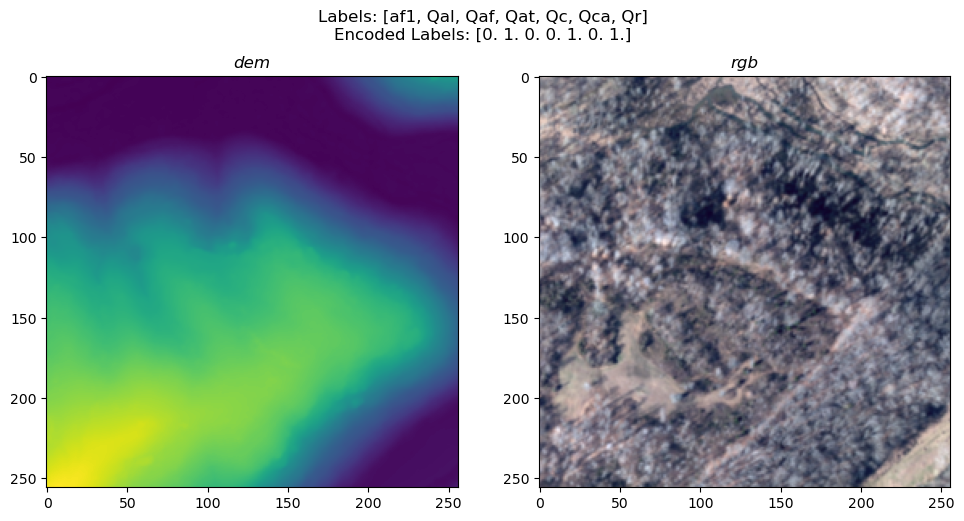

In [10]:
####################
# Visualize Example
####################

##### plot modalities & labels
ncols = 2
nrows = 1
uneven = len(modalities) % ncols
if len(modalities) > ncols:
    if not uneven:
        nrows = len(modalities) / ncols
    else:
        nrows = (len(modalities) // ncols) + 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5*nrows))
ax = ax.ravel()

idx = 0
for modality in example.keys():
    if not 'label' in modality:
        image = prep_image_for_plot(example[modality][0])
        ax[idx].imshow(image)
        ax[idx].set_title(modality, style='italic')
        idx += 1
    else:
        label_vec = example['label'][0].numpy().ravel()

if uneven:
    fig.delaxes(ax[-1])

plt.suptitle(f"Labels: [af1, Qal, Qaf, Qat, Qc, Qca, Qr]\nEncoded Labels: {label_vec}", y=1)
plt.tight_layout()
plt.show()

# **Model**

## *Training*

In [11]:
########################
# Training & Validation
#######################


##### train
train_loss, train_acc, val_loss, val_acc, best_model = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, model_dir)


##### append training data to log...
# collect data
training_data = {}
training_data['training loss'] = train_loss
training_data['training accuracy'] = train_acc
training_data['validation loss'] = val_loss
training_data['validation accuracy'] = val_acc

# append to metadata log
metadata['TRAINING'] = training_data

# write updated metadata log to file
with open(f"{model_dir}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=4)


Epoch 1/3
TRAINING   -- Loss: 0.0389  |  Accuracy: 64.96%  |  Time: 1.13 mins.
VALIDATION -- Loss: 2.1165  |  Accuracy: 23.88%  |  Time: 0.45 mins.
New best model saved with loss 2.1165...
New best model saved with accuracy 23.88%...


Epoch 2/3
TRAINING   -- Loss: 0.3235  |  Accuracy: 53.35%  |  Time: 0.92 mins.
VALIDATION -- Loss: 0.8272  |  Accuracy: 72.54%  |  Time: 0.45 mins.
New best model saved with loss 0.8272...
New best model saved with accuracy 72.54%...


Epoch 3/3
TRAINING   -- Loss: 0.0984  |  Accuracy: 57.81%  |  Time: 1.0 mins.
VALIDATION -- Loss: 0.8160  |  Accuracy: 68.97%  |  Time: 0.45 mins.
New best model saved with loss 0.8160...




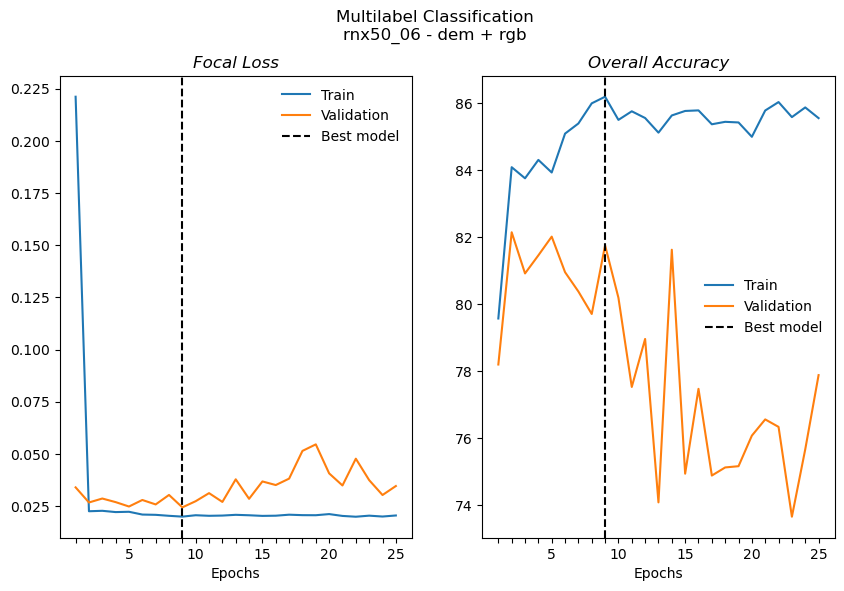

In [9]:
#############################
# Visualize Training Results
#############################

fig, ax = plt.subplots(ncols=2, figsize=(10,6))

epochs = range(1, len(train_loss)+1)

ax[0].plot(epochs, train_loss, label='Train')
ax[0].plot(epochs, val_loss, label='Validation')
ax[0].set_title('Focal Loss', style='italic')

ax[1].plot(epochs, train_acc, label='Train')
ax[1].plot(epochs, val_acc, label='Validation')
ax[1].set_title('Overall Accuracy', style='italic')

for axes in ax:
    axes.axvline(x=best_model, linestyle='--', color='k', label='Best model')
    axes.legend(frameon=False)
    axes.set_xticks(epochs)
    axes.set_xticklabels([str(x) if x%5==0 else '' for x in epochs])
    axes.set_xlabel('Epochs')

modalities_str = list(modalities.keys())[0]
if len(modalities.keys()) > 1:
    for modality in list(modalities.keys())[1:]:
        modalities_str = modalities_str + ' + ' + str(modality)

plt.suptitle(f"Multilabel Classification\n{model_name} - {modalities_str}", y=0.99)
plt.savefig(f"{model_dir}/training_results.jpg")
plt.show()


## *Tuning*

In [9]:
##################
# Load Best Model
##################

# load state dictionary of best model
# state_dict = torch.load(f"{model_dir}/best_loss.pth", map_location=device, weights_only=False)

model_dir = r'../models/classification'
state_dict = torch.load(f"{model_dir}/best_loss.pth", map_location=device, weights_only=False)

# load model with best weights
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
###########################################
# Calculate Optimal Thresholds for Max. F1
###########################################

# calculate optimal thresholds from validation set
optimal_thresholds = calculate_optimal_thresholds(model, val_loader, device)

/Users/matthew/GitHub/cs612/code/utils_training.py:340: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (precision * recall) / (precision + recall)
/opt/miniconda3/envs/cs612/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


## *Inference*

### Warren County Test Set

In [16]:
############################
# Make Test Set Predictions
############################

# get predictions and targets from warren test set
all_predictions, all_targets = test_model(model, test_loader, device)

In [17]:
################################
# Per Label Performance Metrics
################################

df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Accuracy', 'Precision', 'Recall', 'F1', 'AP', 'AUROC'])

for idx, (unit, thresh) in enumerate(zip(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr'], optimal_thresholds)):
    df.loc[idx, 'Class'] = unit + f" ({str(round(thresh, 2))})"
    preds = all_predictions[:, idx]
    targs = all_targets[:, idx]
    acc, precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=thresh)
    ap = average_precision_score(targs, preds)
    df.loc[idx, 'Targets'] = int(targs.sum())
    df.loc[idx, 'Predictions'] = (preds >= thresh).sum()
    df.loc[idx, 'Accuracy'] = acc
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AP'] = ap
    df.loc[idx, 'AUROC'] = auc_roc
df.to_csv(f"{model_dir}/label_metrics_tuned.csv", index=False)
df.head(10)

,Class,Targets,Predictions,Accuracy,Precision,Recall,F1,AP,AUROC
0,af1 (0.48),571,476,0.7454,0.6891,0.5744,0.6266,0.7493,0.8084
1,Qal (0.95),949,8,0.3822,0.5000,0.0042,0.0084,0.7829,0.6974
2,Qaf (0.0),13,1519,0.0195,0.0086,1.0000,0.0170,0.1028,0.8567
3,Qat (0.37),61,68,0.9382,0.2500,0.2787,0.2636,0.2119,0.8332
4,Qc (0.65),749,463,0.7552,0.9028,0.5581,0.6898,0.8558,0.8606
5,Qca (0.51),432,281,0.7897,0.6940,0.4514,0.5470,0.6622,0.8369
6,Qr (0.53),1433,1507,0.9297,0.9396,0.9881,0.9633,0.9732,0.7848


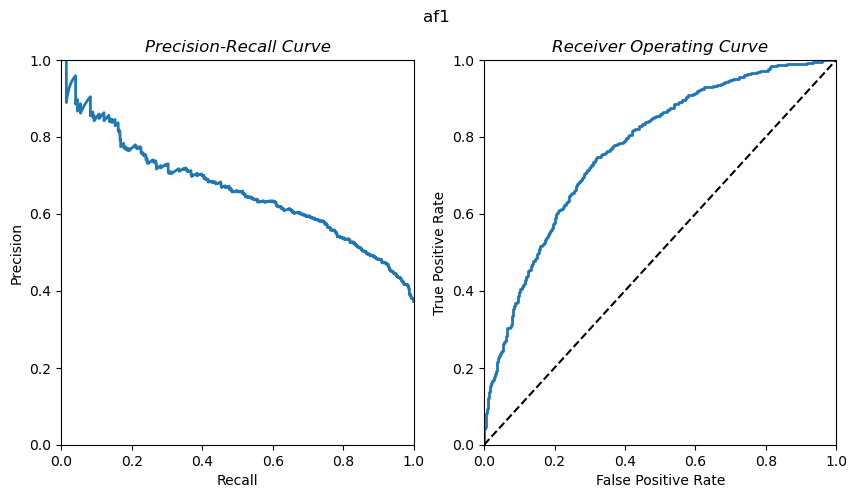

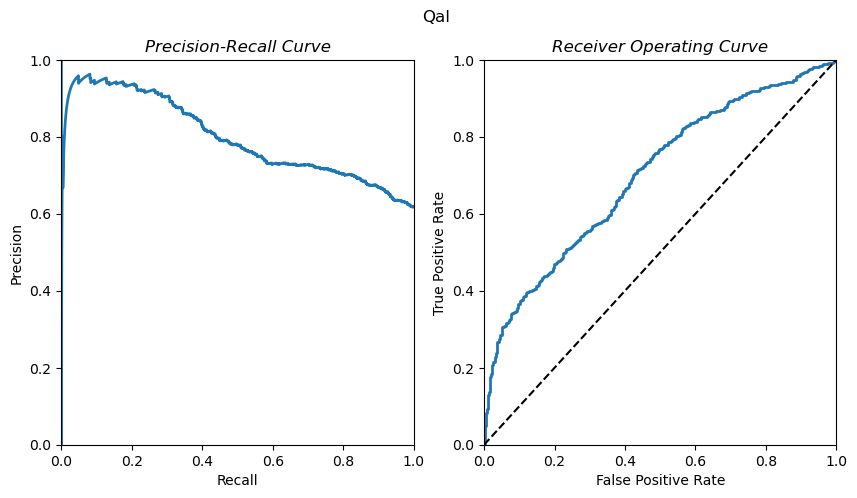

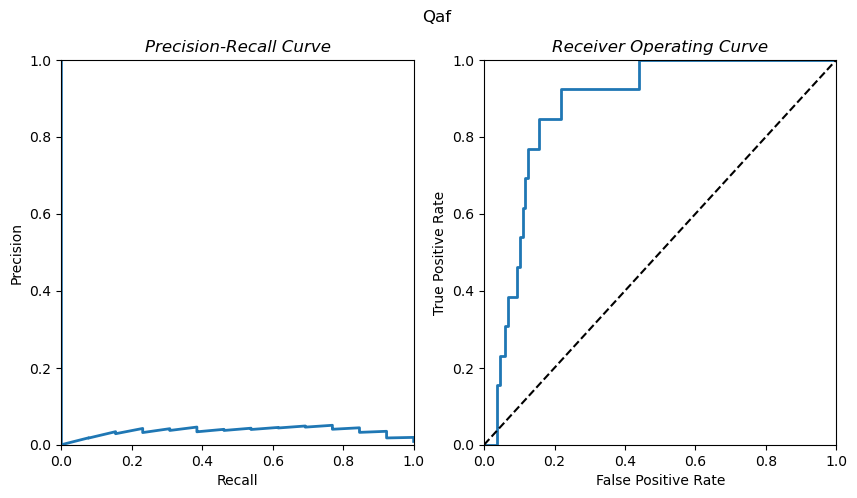

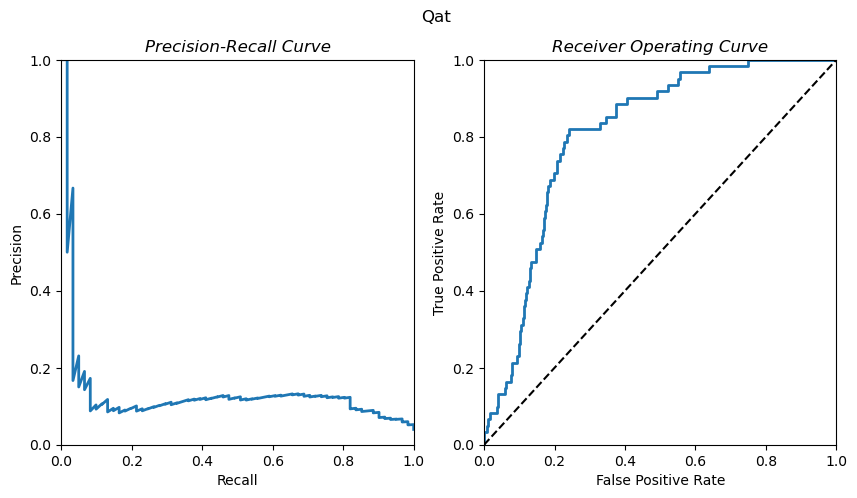

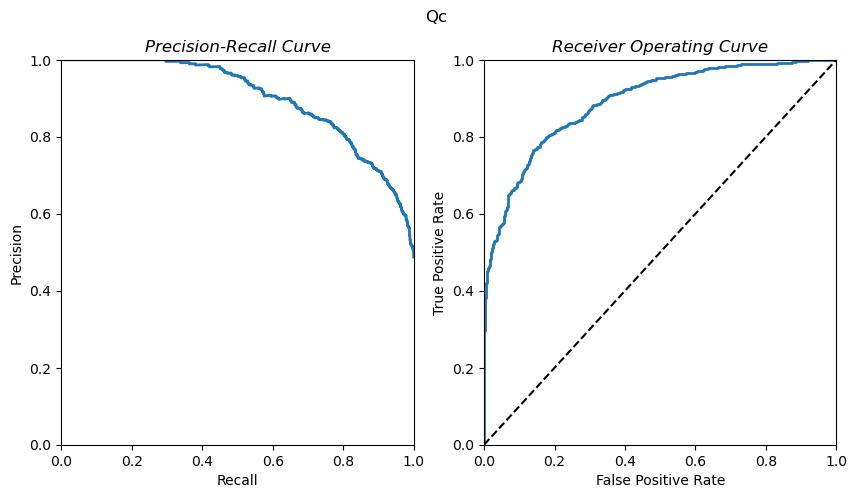

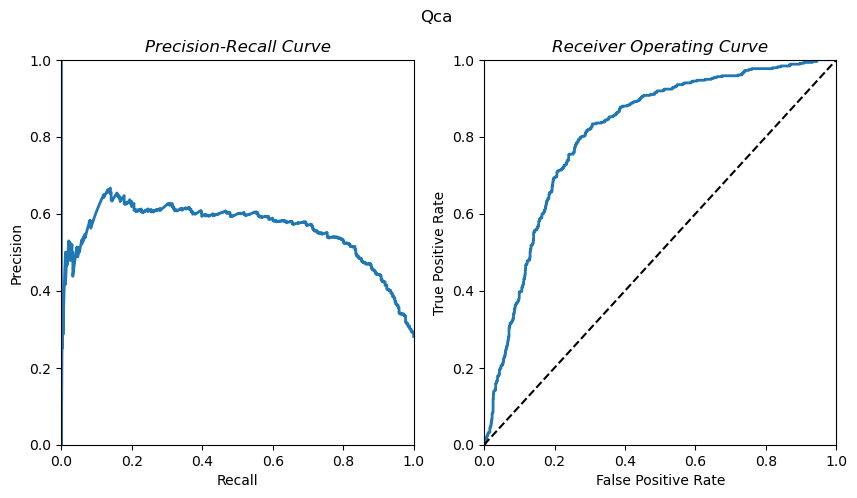

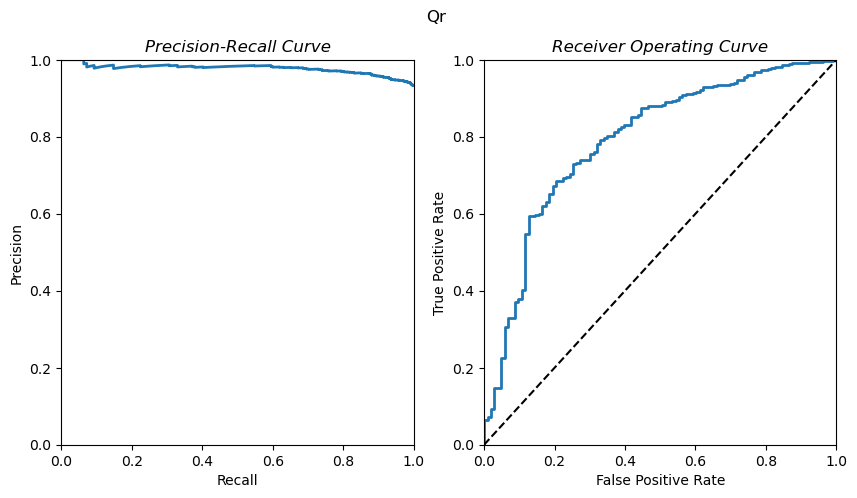

In [14]:
################################
# Precision-Recall & ROC Curves
################################

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):

    fig = plot_label_pr_roc_curves(all_predictions[:, idx], all_targets[:, idx])
    plt.suptitle(unit)
    fig.savefig(f"{model_dir}/{unit}_pr_roc_curves.jpg")
    plt.show(fig)

In [15]:
#############################
# Global Performance Metrics
#############################

macro_precision, weighted_precision, macro_recall, weighted_recall, macro_f1, weighted_f1, macro_mAP, weighted_mAP, h_loss, subset_acc, overall_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=optimal_thresholds)

df = pd.DataFrame({'Overall Accuracy': overall_acc, 
                   'Macro Precision': macro_precision, 
                    'Macro Recall': macro_recall, 
                    'Macro F1': macro_f1, 
                    'Weighted Precision': weighted_precision, 
                    'Weighted Recall': weighted_recall,
                    'Weighted F1': weighted_f1, 
                    'Macro mAP': macro_mAP, 
                    'Weighted mAP': weighted_mAP, 
                    'Hamming Loss': h_loss, 
                    'Subset Accuracy':subset_acc}, index=[0])

df.to_csv(f"{model_dir}/global_metrics_tuned.csv", index=False)
df.head()

,Overall Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Macro mAP,Weighted mAP,Hamming Loss,Subset Accuracy
0,0.8218,0.5398,0.6136,0.5516,0.7362,0.8779,0.7964,0.4782,0.7117,0.1782,0.2155


### Hardin County Test Set

In [16]:
############################
# Make Test Set Predictions
############################

# get predictions and targets from warren test set
all_predictions, all_targets = test_model(model, hardin_test_loader, device)

In [17]:
################################
# Per Label Performance Metrics
################################

df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Accuracy', 'Precision', 'Recall', 'F1', 'AP', 'AUROC'])

for idx, (unit, thresh) in enumerate(zip(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr'], optimal_thresholds)):
    df.loc[idx, 'Class'] = unit + f" ({str(round(thresh, 2))})"
    preds = all_predictions[:, idx]
    targs = all_targets[:, idx]
    acc, precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=thresh)
    ap = average_precision_score(targs, preds)
    df.loc[idx, 'Targets'] = int(targs.sum())
    df.loc[idx, 'Predictions'] = (preds >= thresh).sum()
    df.loc[idx, 'Accuracy'] = acc
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AP'] = ap
    df.loc[idx, 'AUROC'] = auc_roc
df.to_csv(f"{model_dir}/label_metrics_tuned_hardin.csv", index=False)
df.head(10)

,Class,Targets,Predictions,Accuracy,Precision,Recall,F1,AP,AUROC
0,af1 (0.42),435,551,0.7565,0.5554,0.7034,0.6207,0.5819,0.7924
1,Qal (0.47),845,1535,0.5495,0.5498,0.9988,0.7092,0.5546,0.5148
2,Qaf (0.3),6,5,0.9928,0.0000,0.0000,0.0000,0.0035,0.3916
3,Qat (0.54),77,0,0.9499,0.0000,0.0000,0.0000,0.0466,0.5053
4,Qc (0.44),456,917,0.6543,0.4591,0.9232,0.6133,0.7059,0.8499
5,Qca (0.52),249,453,0.7487,0.3488,0.6345,0.4501,0.4104,0.7681
6,Qr (0.11),1511,1536,0.9837,0.9837,1.0000,0.9918,0.9937,0.7263


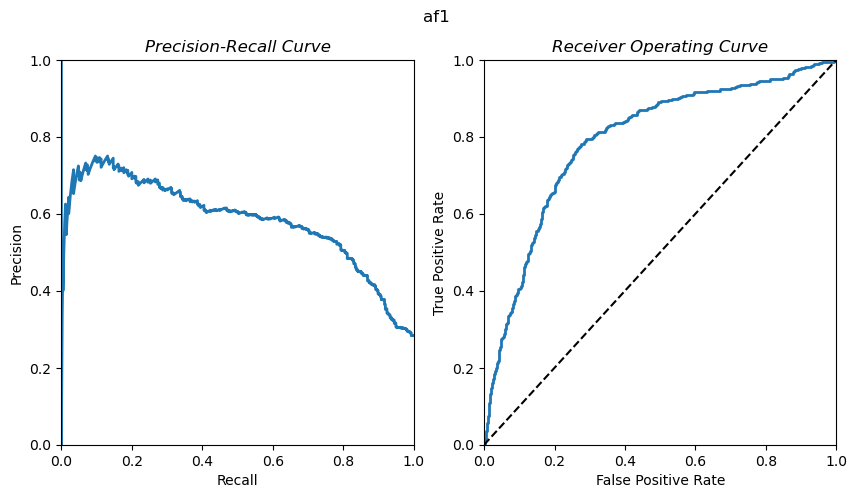

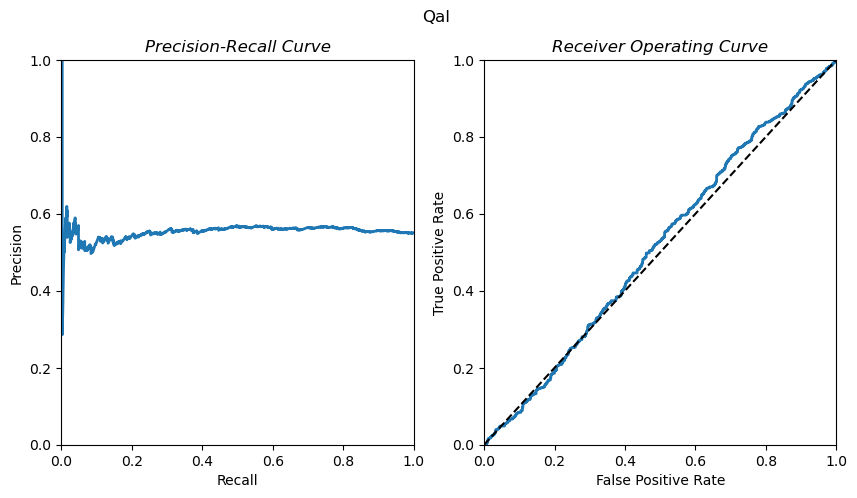

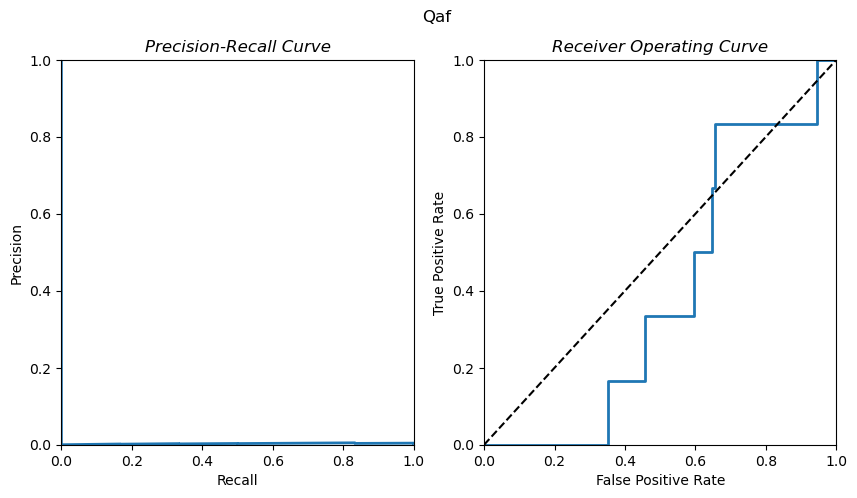

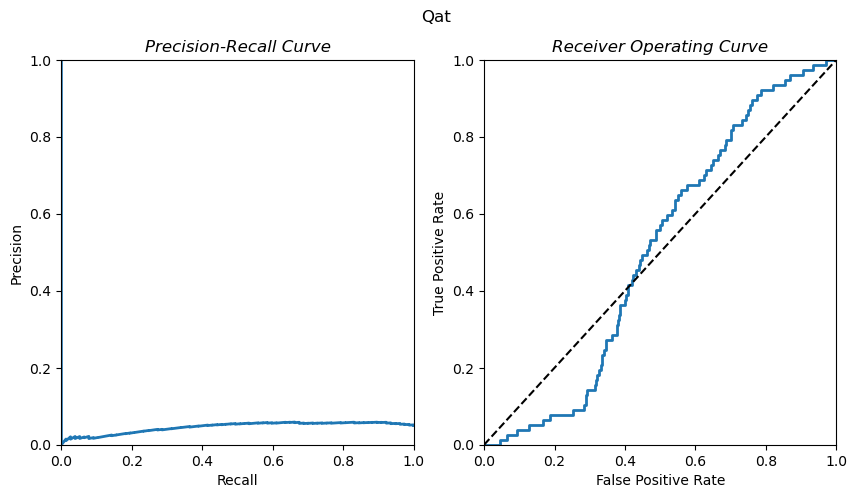

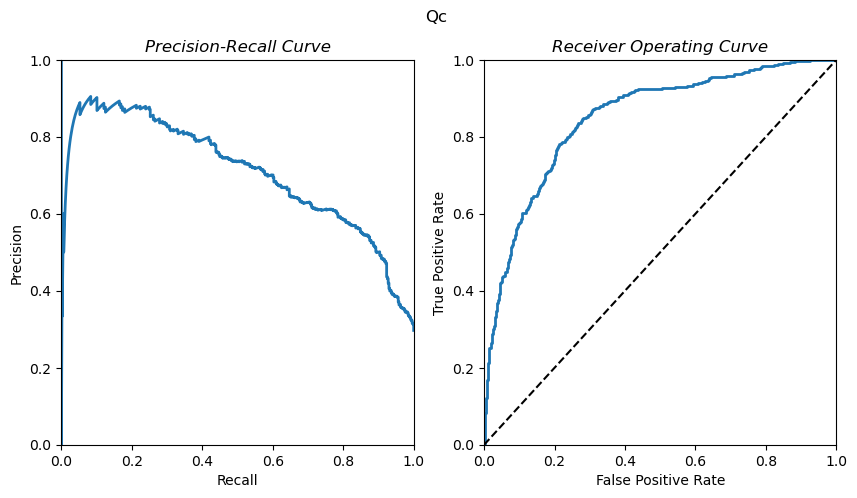

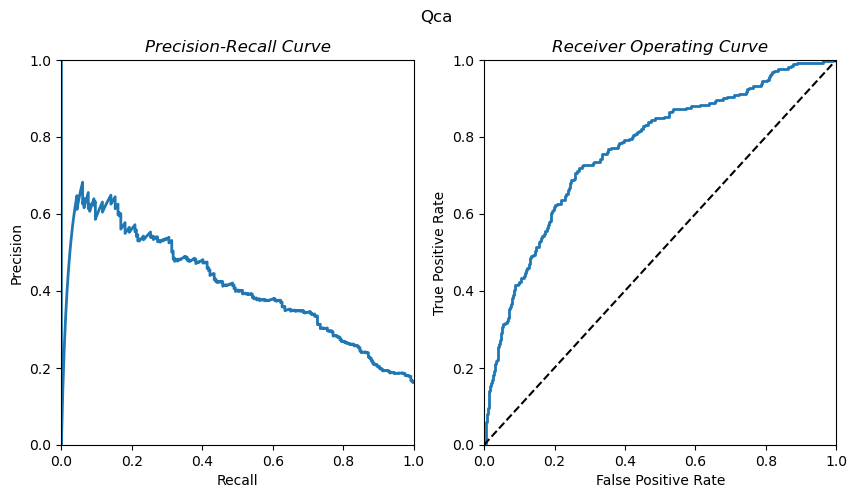

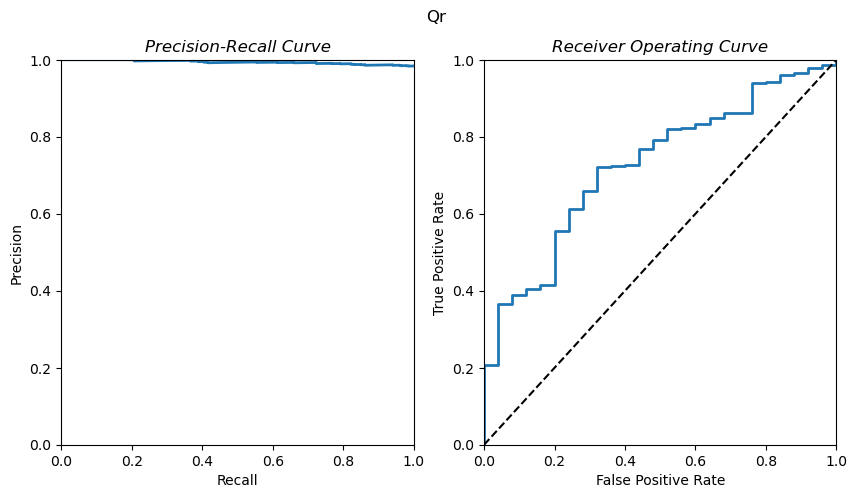

In [18]:
################################
# Precision-Recall & ROC Curves
################################

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):

    fig = plot_label_pr_roc_curves(all_predictions[:, idx], all_targets[:, idx])
    plt.suptitle(unit)
    fig.savefig(f"{model_dir}/{unit}_pr_roc_curves_hardin.jpg")
    plt.show(fig)

In [19]:
#############################
# Global Performance Metrics
#############################

macro_precision, weighted_precision, macro_recall, weighted_recall, macro_f1, weighted_f1, macro_mAP, weighted_mAP, h_loss, subset_acc, overall_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=optimal_thresholds)

df = pd.DataFrame({'Overall Accuracy': overall_acc, 
                   'Macro Precision': macro_precision, 
                    'Macro Recall': macro_recall, 
                    'Macro F1': macro_f1, 
                    'Weighted Precision': weighted_precision, 
                    'Weighted Recall': weighted_recall,
                    'Weighted F1': weighted_f1, 
                    'Macro mAP': macro_mAP, 
                    'Weighted mAP': weighted_mAP, 
                    'Hamming Loss': h_loss, 
                    'Subset Accuracy':subset_acc}, index=[0])

df.to_csv(f"{model_dir}/global_metrics_tuned_hardin.csv", index=False)
df.head()

c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mamass1\AppData\Local\miniconda3\envs\cs612\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Overall Accuracy,Macro Precision,Macro Recall,Macro F1,Weighted Precision,Weighted Recall,Weighted F1,Macro mAP,Weighted mAP,Hamming Loss,Subset Accuracy
0,0.8051,0.4138,0.6086,0.4836,0.6954,0.9053,0.7711,0.3985,0.6803,0.1949,0.1842


In [ ]:
# parameters...
# output_dir = r'../models/classification/model_01'
# out_classes = 7
# modality_channels = {'rgb': 3, 'dem': 1}
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = FullModel(out_classes=out_classes, modality_channels=modality_channels).to(device)
# state_dict = torch.load(f"{model_dir}/best_loss.pth", map_location=device, weights_only=False)
# model.load_state_dict(state_dict)

In [18]:
# all_predictions, all_targets = test_model(model, test_loader, device)

In [ ]:
# df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AUROC'])

# for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):
#     df.loc[idx, 'Class'] = unit
#     preds = all_predictions[:, idx]
#     targs = all_targets[:, idx]
#     precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=0.5)
#     df.loc[idx, 'Targets'] = int(targs.sum())
#     df.loc[idx, 'Predictions'] = (preds >= 0.5).sum()
#     df.loc[idx, 'Precision'] = precision
#     df.loc[idx, 'Recall'] = recall
#     df.loc[idx, 'F1'] = f1
#     df.loc[idx, 'AUROC'] = auc_roc
# df.to_csv(f"{model_dir}/label_metrics.csv", index=False)
# df.head(10)


In [ ]:
# ##### Visualizations - Precision-Recall Curve & ROC Curve

# for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):

#     fig = plot_label_pr_roc_curves(all_predictions[:,idx], all_targets[:, idx])
#     plt.suptitle(unit)
#     fig.savefig(f"{model_dir}/{unit}_pr_roc_curves.jpg")
#     plt.show(fig)


In [ ]:
# ##### Averaged over all labels - Precision, Recall, F1, AUC-ROC, & mean Average Precision (mAP), Hamming loss, Subset Accuracy
# macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=[0.5])

# df = pd.DataFrame({'Macro Precision': macro_precision, 
#                    'Macro Recall': macro_recall, 
#                    'Macro F1': macro_f1, 
#                    'mAP': mean_ap, 
#                    'Hamming Loss': h_loss, 
#                    'Subset Accuracy':subset_acc}, index=[0])

# df.to_csv(f"{model_dir}/global_metrics.csv", index=False)
# df.head()

In [28]:
# def calculate_optimal_thresholds(model, val_loader, device):
  
#   all_predictions = []
#   all_targets = []

#   model.eval()

#   with torch.no_grad():
#     for batch in val_loader:
      
#       labels = batch.pop('label').squeeze(1).to(device)
#       modalities = {modality: data.to(device) for modality, data in batch.items()}
#       outputs = model(modalities)
#       predictions = torch.sigmoid(outputs)
#       all_targets.append(labels.cpu().numpy())
#       all_predictions.append(predictions.cpu().numpy())
  
#   all_predictions = np.concatenate(all_predictions)
#   all_targets = np.concatenate(all_targets)

#   optimal_thresholds = []

#   for class_idx in range (all_predictions.shape[1]):
#     precision, recall, thresholds = precision_recall_curve(all_targets[:, class_idx], all_predictions[:, class_idx])
#     f1 = 2 * (precision * recall) / (precision + recall)
#     best_idx = np.argmax(f1)
#     best_threshold = thresholds[best_idx]
#     optimal_thresholds.append(best_threshold)

#   return optimal_thresholds

In [ ]:
# optimal_thresholds = calculate_optimal_thresholds(model, val_loader, device)
# optimal_thresholds

In [ ]:
# df = pd.DataFrame(columns=['Class', 'Targets', 'Predictions', 'Precision', 'Recall', 'F1', 'AUROC'])

# for idx, (unit, thresh) in enumerate(zip(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr'], optimal_thresholds)):
#     df.loc[idx, 'Class'] = unit + f" ({str(round(thresh, 2))})"
#     preds = all_predictions[:, idx]
#     targs = all_targets[:, idx]
#     precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=thresh)
#     df.loc[idx, 'Targets'] = int(targs.sum())
#     df.loc[idx, 'Predictions'] = (preds >= thresh).sum()
#     df.loc[idx, 'Precision'] = precision
#     df.loc[idx, 'Recall'] = recall
#     df.loc[idx, 'F1'] = f1
#     df.loc[idx, 'AUROC'] = auc_roc
# df.to_csv(f"{model_dir}/label_metrics_tuned.csv", index=False)
# df.head(10)

In [ ]:
# macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(all_targets, all_predictions, thresholds=optimal_thresholds)

# df = pd.DataFrame({'Macro Precision': macro_precision, 
#                    'Macro Recall': macro_recall, 
#                    'Macro F1': macro_f1, 
#                    'mAP': mean_ap, 
#                    'Hamming Loss': h_loss, 
#                    'Subset Accuracy':subset_acc}, index=[0])

# df.to_csv(f"{model_dir}/global_metrics_tuned.csv", index=False)
# df.head()